In [1]:
import pickle
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.svm import SVC   # Support Vector Classifier for training the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelBinarizer   # For scaling features and binarizing labels
import matplotlib.pyplot as plt # For visualizations
import seaborn as sns   # For heatmap

In [2]:
def load_and_preprocess_image(path, target_size):
    img = load_img(path, target_size=target_size)  # Load image from path with specified target size
    img_array = img_to_array(img)  # Convert image to array
    preprocessed_img = preprocess_input(img_array)  # Preprocess the image using VGG16 preprocessing
    flattened_img = preprocessed_img.flatten()  # Flatten the image array to 1D
    return flattened_img

def get_data_for_training(excel_path, image_size=(32, 32)):
    df = pd.read_excel(excel_path)  
    df = df.dropna(subset=['image_path'])  

    df = df.drop(columns=['Dataset'])  # Drop the 'Dataset' column

    x = []  
    y = []  
    image_paths = []  

    # Iterate through each row in the dataframe
    for idx, row in df.iterrows():
        image_path = row['image_path']  # Get image path
        label = row.drop('image_path').idxmax()  # Get the label (the column with the maximum value)

        image = load_and_preprocess_image(image_path, image_size)  # Load and preprocess the image

        x.append(image)  
        y.append(label)  
        image_paths.append(image_path)  

    x = np.array(x)  
    y = np.array(y)  

    return x, y, image_paths  

In [3]:
# File paths to training and validation data
train_excel_path = "training/training_data.xlsx"
val_excel_path = "validation/validation_data.xlsx"
image_size = (32, 32)   # Reduced image size to save memory
batch_size = 4096

# Load and preprocess training and validation data
X_train, y_train, _ = get_data_for_training(train_excel_path, image_size=image_size)
print("train data loaded")
X_val, y_val, image_paths = get_data_for_training(val_excel_path, image_size=image_size)
print("val data loaded")

train data loaded
val data loaded


In [4]:
# Standardize the features by removing the mean and scaling to unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
print("scaling complete")

scaling complete


In [5]:
# Initialize and train the SVM model
svm_model = SVC(kernel='rbf', probability=   True)  
svm_model.fit(X_train, y_train)
print("training complete")

training complete


In [6]:
#printing accuracy
y_pred = svm_model.predict(X_val)
y_pred_proba = svm_model.predict_proba(X_val)
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy}")

Validation accuracy: 0.81886932804364


In [7]:
# Save validation predictions to an Excel file
results_df = pd.DataFrame({
    'Image_path': image_paths,
    'actual_class': y_val,
    'predicted_class': y_pred
})
results_df.to_excel("results.xlsx", index=False)

In [8]:
# Print the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_val, y_pred, normalize='true')
print(cm)

Confusion Matrix:
[[3.21931590e-01 0.00000000e+00 1.28772636e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.47283702e-01 2.01207243e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.62116992e-01 1.14206128e-01 5.57103064e-03
  0.00000000e+00 0.00000000e+00 4.93036212e-01 1.39275766e-02
  1.11420613e-02 0.00000000e+00]
 [8.65800866e-04 4.32900433e-03 3.16017316e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 6.72727273e-01 6.06060606e-03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.36700337e-03 2.52525253e-01 3.03030303e-02
  0.00000000e+00 0.00000000e+00 7.13804714e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.94117647e-03 0.00000000e+00 9.11764706e-02 2.94117647e-03
  3.32352941e-01 0.00000000e+00 5.70588235e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.02040816e-01 0.00000000e+00
  0.00000000e+00 1.31195335e-01 7.55102041e-01 8.74635569e-03
  2.91545190e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.562627

In [9]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

Classification Report:
                  precision    recall  f1-score   support

    Angioectasia       0.98      0.32      0.48       497
        Bleeding       0.93      0.36      0.52       359
         Erosion       0.40      0.32      0.35      1155
        Erythema       0.69      0.03      0.06       297
    Foreign Body       0.99      0.33      0.50       340
Lymphangiectasia       1.00      0.13      0.23       343
          Normal       0.84      0.98      0.91     12287
           Polyp       0.63      0.08      0.14       500
           Ulcer       0.95      0.72      0.82       286
           Worms       0.92      0.81      0.86        68

        accuracy                           0.82     16132
       macro avg       0.83      0.41      0.49     16132
    weighted avg       0.81      0.82      0.78     16132



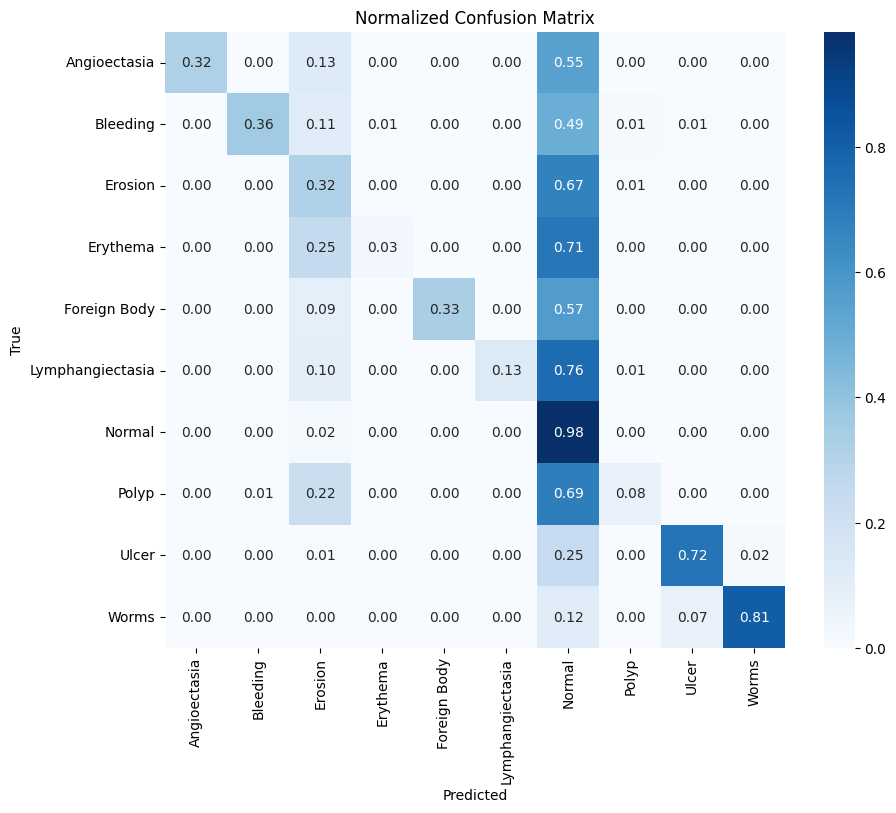

In [10]:
# printing the normalized confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

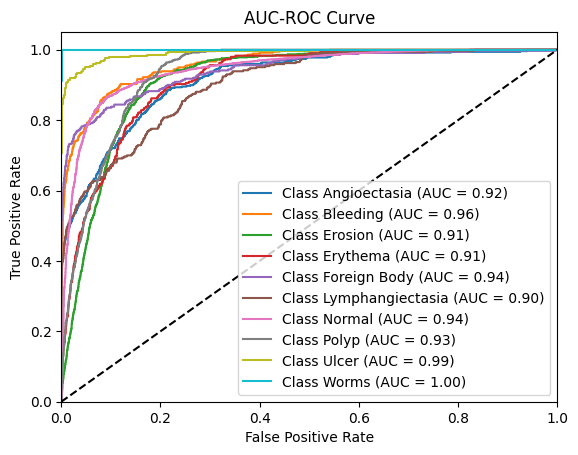

In [11]:
# Plot AUC-ROC curve
lb = LabelBinarizer()
y_val_bin = lb.fit_transform(y_val)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(lb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = roc_auc_score(y_val_bin[:, i], y_pred_proba[:, i])

plt.figure()
for i in range(len(lb.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {lb.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [12]:
#saving the model for future use
pickle.dump(svm_model,open('SVMclassifier.p','wb'))
print("Model saved successfully")

Model saved successfully


### Code Contributed by Manya Joshi